In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [17]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 200
dim = 2
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, dim)
CFL = 0.3
goalRadius = 0.8

nx = 256
rho0 = 1
E0 = 1
gamma = 5/3

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.CullenHopkins
supportScheme = AdaptiveSupportScheme.OwenScheme

domain = buildDomainDescription(l = 1, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([0, 0], device = device, dtype = dtype)
domain.max = torch.tensor([1, 1], device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [18]:
particles_l = sampleRegularParticles(nx, domain, targetNeighbors, jitter = 0.0)

True: dxs: [tensor(0.0039, device='cuda:0'), tensor(0.0039, device='cuda:0')], ns: [tensor(256, device='cuda:0', dtype=torch.int32), tensor(256, device='cuda:0', dtype=torch.int32)], nx: 256


In [19]:
rho1 = 1.0
rho2 = 2.0
rhom = (rho1 - rho2) / 2
v1 = 0.5
v2 = -0.5
vm = (v1 - v2) / 2
delta = 0.025
delta_y = 0.01
lamda = 1/2

In [20]:
import numpy as np
v_y = delta_y * torch.sin(2 * np.pi * particles_l.positions[:, 0] / lamda)

In [21]:
region1 = torch.logical_and(particles_l.positions[:, 1] >= 0, particles_l.positions[:, 1] < 1/4)
region2 = torch.logical_and(particles_l.positions[:, 1] >= 1/4, particles_l.positions[:, 1] < 1/2)
region3 = torch.logical_and(particles_l.positions[:, 1] >= 1/2, particles_l.positions[:, 1] < 3/4)
region4 = torch.logical_and(particles_l.positions[:, 1] >= 3/4, particles_l.positions[:, 1] <= 1)

rho = torch.zeros_like(particles_l.densities)

rho[region1] = rho1 - rhom * torch.exp((particles_l.positions[region1, 1] - 1/4) / delta)
rho[region2] = rho2 + rhom * torch.exp((1/4 - particles_l.positions[region2, 1]) / delta)
rho[region3] = rho2 + rhom * torch.exp((particles_l.positions[region3, 1] - 3/4) / delta)
rho[region4] = rho1 - rhom * torch.exp((3/4 - particles_l.positions[region4, 1]) / delta)

print(f'rho1 = {rho1}, rho2 = {rho2}, rhom = {rhom}')
print(f'rho min = {rho.min()}, rho max = {rho.max()}, mean = {rho.mean()}')


v_x = torch.zeros_like(particles_l.positions[:, 0])
v_x[region1] = v1 - vm * torch.exp((particles_l.positions[region1, 1] - 1/4) / delta)
v_x[region2] = v2 + vm * torch.exp((1/4 - particles_l.positions[region2, 1]) / delta)
v_x[region3] = v2 + vm * torch.exp((particles_l.positions[region3, 1] - 3/4) / delta)
v_x[region4] = v1 - vm * torch.exp((3/4 - particles_l.positions[region4, 1]) / delta)

print(f'v1 = {v1}, v2 = {v2}, vm = {vm}')
print(f'v min = {v_x.min()}, v max = {v_x.max()}, mean = {v_x.mean()}')

v_initial = torch.stack([v_x, v_y], dim = 1)

rho1 = 1.0, rho2 = 2.0, rhom = -0.5
rho min = 1.0000245571136475, rho max = 1.9999754428863525, mean = 1.5
v1 = 0.5, v2 = -0.5, vm = 0.5
v min = -0.49997544288635254, v max = 0.49997544288635254, mean = 0.0


In [22]:
Pinitial = torch.ones_like(rho) * 2.5

In [ ]:
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = rho, gamma = gamma)
# v_initial = torch.zeros_like(particles_l.positions)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses * rho,
    densities = rho,        
    velocities = v_initial,
    
    kinds = torch.zeros_like(particles_l.positions[:,0], dtype = torch.int32),
    materials = torch.zeros_like(particles_l.positions[:,0], dtype = torch.int32),
    UIDs = torch.arange(particles_l.positions.shape[0], device = device, dtype = torch.int32),

    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities)
)

from sphMath.neighborhood import evaluateNeighborhood, filterNeighborhoodByKind, SupportScheme
neighborhood, neighbors = evaluateNeighborhood(simulationState, domain, kernel, verletScale = 1.0, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
numNeighbors = coo_to_csr(filterNeighborhoodByKind(simulationState, neighbors.neighbors, which = 'noghost')).rowEntries
densities = computeDensity(simulationState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)
print(densities.min(), densities.max(), densities.mean())

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = simulationState.densities, gamma = gamma)
simulationState.internalEnergies = u_


particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )


timeLimit = 2
dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
# dt = torch.tensor(1e-4, dtype = dtype, device = device)
timesteps = int(timeLimit / dt)
simulationState = copy.deepcopy(particleSystem)
print(dt, timesteps)

tensor(1.0000, device='cuda:0') tensor(2.0000, device='cuda:0') tensor(1.5000, device='cuda:0')
tensor(0.0006, device='cuda:0') 6850


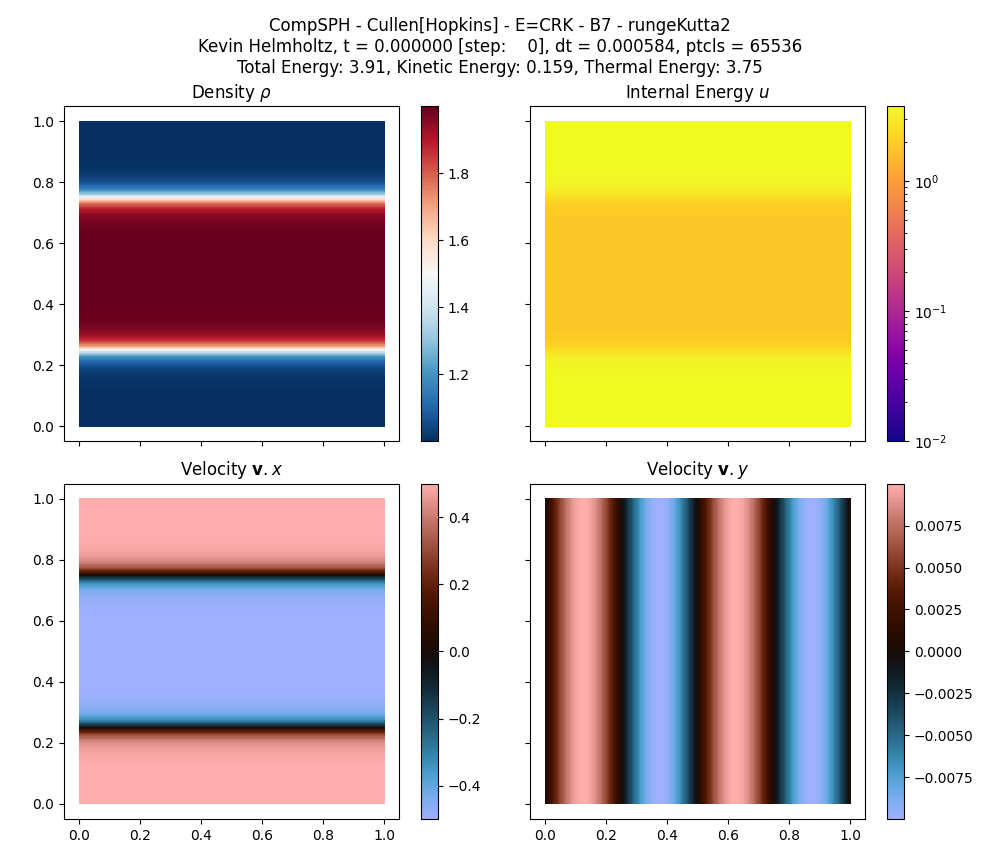

In [24]:
from sphMath.plotting import visualizeParticles, updatePlot
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH, evaluateOptimalSupportOwen

fluidParticles = simulationState.systemState

fig, axis = plt.subplots(2, 2, figsize=(10, 8.5), squeeze=False, sharex=True, sharey=True)

s = 0.1
densityPlotState = visualizeParticles(fig, axis[0,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.densities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                    #  scaling = 'sym',
                     cmap = 'RdBu_r',
                     midPoint=1.5,
                     title='Density $\\rho$',
                     markerSize = s,
                     gridVisualization=True, gridResolution=256)

internalEnergyPlotState = visualizeParticles(fig, axis[0,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.internalEnergies, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'plasma',
                     title='Internal Energy $u$',
                     scaling = 'log',
                     vmin = 1e-2,
                     markerSize = s,
                     gridVisualization=True, gridResolution=256)

velocityXPlotState = visualizeParticles(fig, axis[1,0],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.velocities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'berlin',
                     midPoint=0,
                     title='Velocity $\mathbf{v}.x$',
                     mapping = '.x',
                     markerSize = s,
                     gridVisualization=True, gridResolution=256)
velocityYPlotState = visualizeParticles(fig, axis[1,1],
                     particles = fluidParticles, 
                     domain = domain, 
                     quantity = fluidParticles.velocities, 
                     which = 'fluid',
                     visualizeBoth=False,
                     kernel = solverConfig['kernel'],
                     plotDomain = False,
                     cmap = 'berlin',
                     midPoint=0,
                     title='Velocity $\mathbf{v}.y$',
                     mapping = '.y',
                     markerSize = s,
                     gridVisualization=True, gridResolution=256)

# for ax in axis.flatten():
    # ax.set_xlim(-1, 1)
    # ax.set_ylim(-1,1)
kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
totalEnergy = kineticEnergy + thermalEnergy
    
    
fig.suptitle(f'{solverConfig["schemeName"]}\nKevin Helmholtz, t = {simulationState.t:2f} [step: {0:4d}], dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')
# fig.suptitle(f'{solverConfig["schemeName"]}\nSedov-Taylor Explosion, t = {simulationState.t:2f} [step: {0:4d}], dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')

fig.tight_layout()


In [25]:

import math
fps = 50
exportInterval = 1 / fps
exportSteps = int(math.ceil(exportInterval / dt))
newDt = exportInterval / exportSteps
plotInterval = int(math.floor(exportInterval / newDt))
plotInterval = min(max(plotInterval,1), 40)
print(f'Current dt: {dt}')
print(f'Plot Interval: {plotInterval}')
print(f'export Steps: {exportSteps}')
print(f'New dt: {newDt}')

imagePrefix = './images/KevinHelmholtz/'
os.makedirs(imagePrefix, exist_ok = True)

fig.savefig(f'{imagePrefix}frame_{0:05d}.png', dpi = 100)

Current dt: 0.0005839256918989122
Plot Interval: 35
export Steps: 35
New dt: 0.0005714285714285715


In [27]:
states = []
dt = newDt
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
for i in (tq:=tqdm(range(timesteps))):
# while(True):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = simulationState.priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    # if i%100 == 0:
        # states.append(copy.deepcopy(simulationState).to(dtype = torch.float32, device = 'cpu'))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item() if torch.is_tensor(simulationState.t) else simulationState.t,
    })

    if (i % plotInterval == 0 and i > 0) or i == timesteps - 1:
        updatePlot(densityPlotState, simulationState.systemState, simulationState.systemState.densities)
        updatePlot(internalEnergyPlotState, simulationState.systemState, simulationState.systemState.internalEnergies)
        updatePlot(velocityXPlotState, simulationState.systemState, simulationState.systemState.velocities, mapping = '.x')
        updatePlot(velocityYPlotState, simulationState.systemState, simulationState.systemState.velocities, mapping = '.y')
        
        # for ax in axis.flatten():
            # ax.set_xlim(-1, 1)
            # ax.set_ylim(-1,1)
        
        fig.suptitle(f'{solverConfig["schemeName"]}\nKevin Helmholtz, t = {simulationState.t:2f} [step: {i:4d}], dt = {dt:.3g}, ptcls = {len(simulationState.systemState.positions)}\nTotal Energy: {totalEnergy:.3g}, Kinetic Energy: {kineticEnergy:.3g}, Thermal Energy: {thermalEnergy:.3g}')


        fig.canvas.draw()
        fig.canvas.flush_events()
        fig.savefig(f'{imagePrefix}frame_{i:05d}.png', dpi = 100)

  0%|          | 0/6850 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from sphMath.util import postProcess

postProcess(
    imagePrefix = imagePrefix,
    fps = 50,
    exportName = 'kevin_helmholtz',
    targetLongEdge = 600
)
# def postProcess(imagePrefix, fps, exportName, targetLongEdge = 600):

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 850) to (1008, 864) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Copying video to videos folder
Done!
